# SGTCS Adversarial Perturbation Technique

## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Loading MobileNet

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

##### Helper Functions

In [3]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

def display_images(image, description, label, confidence):
    
    plt.figure()
    
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,label, confidence*100))
    
    plt.show()

## Original Image

In [4]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 0s 244ms/step


In [5]:
get_imagenet_label(image_probs)

('n02099712', 'Labrador_retriever', 0.4181851)

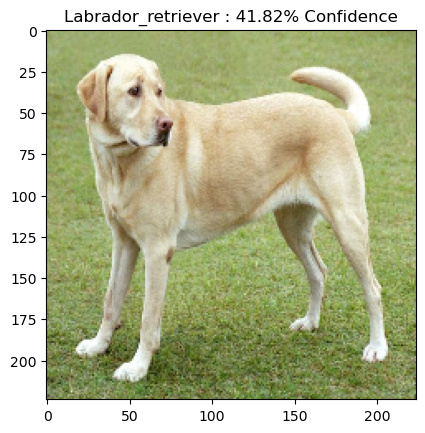

In [6]:
plt.figure()

plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))

plt.show()

## Creating an Adversarial Image using SGTCS

In [7]:
# SGTCS Adversarial Perturbation
def generate_sgtcs_perturbation(model, x, epsilon=0.1, alpha=0.01, num_iter=100):
    perturbation = np.zeros_like(x)
    for _ in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x)
            loss = tf.keras.losses.sparse_categorical_crossentropy([208], model(x))
        gradient = tape.gradient(loss, x)
        perturbation += alpha * np.sign(gradient)
        perturbation = np.clip(perturbation, -epsilon, epsilon)
        x_adv = x + perturbation
        x_adv = np.clip(x_adv, 0, 1)  
    return x_adv


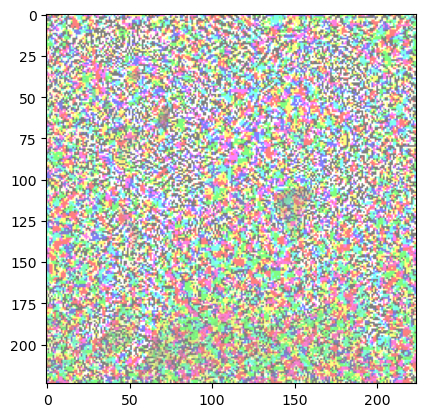

In [8]:
perturbation = generate_sgtcs_perturbation(model=pretrained_model, x=image,epsilon=1)
plt.imshow(perturbation[0] * 0.5 + 0.5);

In [9]:
def sgtcs(model, image, epsilon):
    perturbed_image = generate_sgtcs_perturbation(model=model, x=image, epsilon=epsilon)
    predictions = model.predict(perturbed_image)
    return predictions, perturbed_image

In [10]:
epsilons = [0, 0.1, 0.15, 0.2, 0.25]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]
descriptions

['Input',
 'Epsilon = 0.100',
 'Epsilon = 0.150',
 'Epsilon = 0.200',
 'Epsilon = 0.250']

1/1 [==============================] - 0s 24ms/step


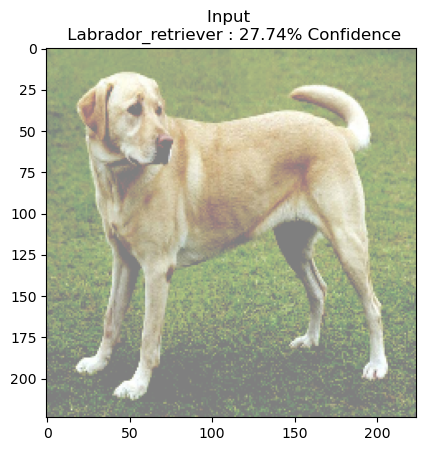

1/1 [==============================] - 0s 24ms/step


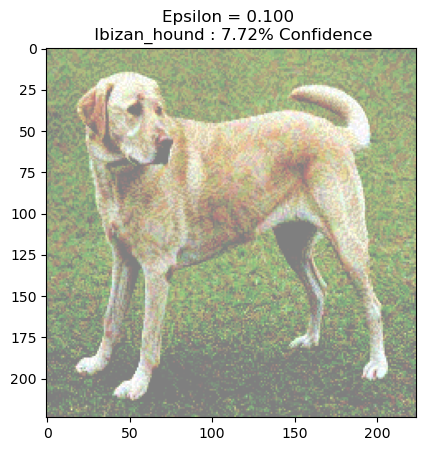

1/1 [==============================] - 0s 24ms/step


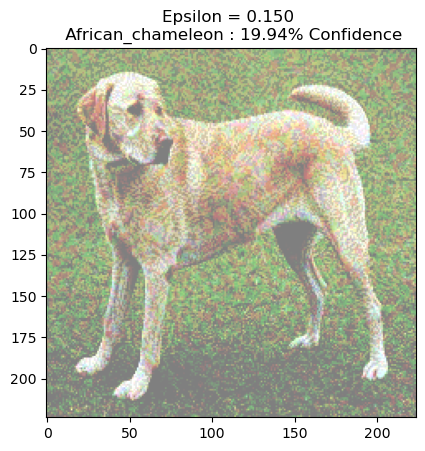

1/1 [==============================] - 0s 29ms/step


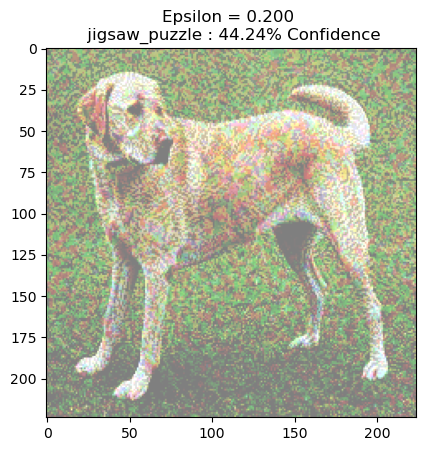

1/1 [==============================] - 0s 21ms/step


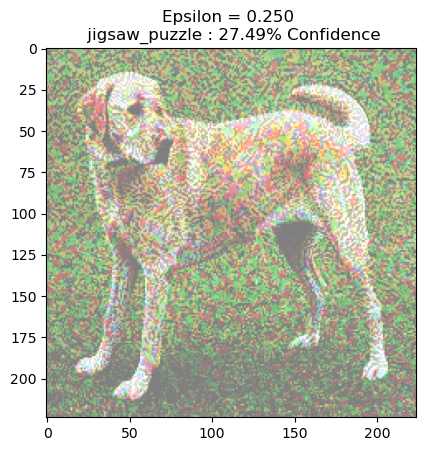

In [11]:
for i,e in enumerate(epsilons):
    
    # Generate adversarial example using CTC
    results, perbuted_image = sgtcs(model=pretrained_model, image=image, epsilon=e)
    results = get_imagenet_label(results)
    
    display_images(image=perbuted_image, description=descriptions[i],label=results[1],confidence=results[2])